# Autonomous Driving - Visual Odometry for Localization

This notebook will walk you through the process of visual odometry for autonomous driving. The entire process has been broken down into following steps:
1. Extract features from the photographs taken with a camera setup on the vehicle
2. Use the extracted features to find matches between the features in the different photographs.
3. Use the found matches to estimate the camera motion between subsequent photographs.
4. Use the estimated camera motion to build the vehicle trajectory.

## Importing Packages
First, we will start with importing the necessary packages required for the project. Following code does that for you. Also, we will be importing `helper_functions` package that includes a `DataSetHandler` class. This class includes necessary methods to load and processes images for various applications throughout the project.

In [31]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from helper_functions import *

np.set_printoptions(suppress = True)

## 0 - Loading and Visualizing the Data
Run the following code to create a dataset handler object.

In [2]:
dataset_handler = DatasetHandler()

The dataset contains 52 frames of data. Each frame contains an RGB image and a depth map taken with a setup on the vehicle and a grayscale version of the RGB image which will be used for computation. Furthermore, camera caliberation matrix $K$ is also provided in the dataset handler.

Upon creation of the dataset handler object, all the frames will be automatically read and loaded. The frame content can be accessed by using `images`, `images_rgb`, `depth_maps` attributes of the dataset handler object along with the index of the requested frame. See how to access the images (grayscale), rgb images (3-channel color), depth maps and camera calibration matrix in the example below.

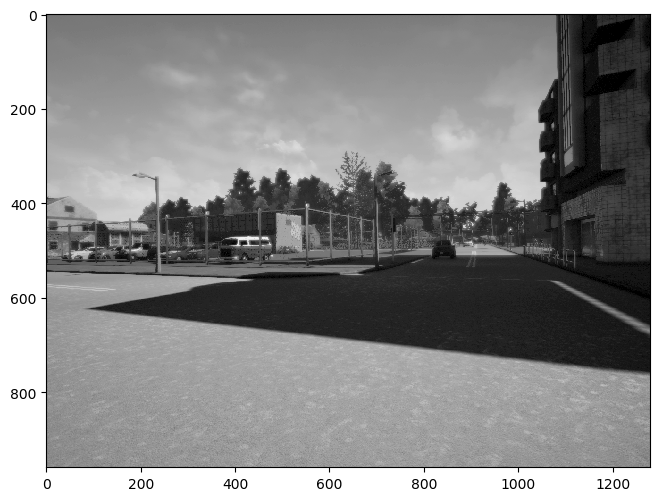

In [3]:
image = dataset_handler.images[0]

plt.figure(figsize = (8,6), dpi = 100)
plt.imshow(image, cmap = 'gray')

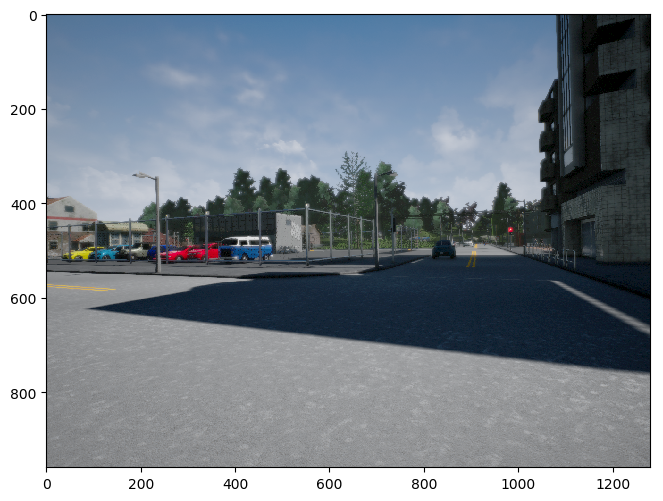

In [4]:
image_rgb = dataset_handler.images_rgb[0]

plt.figure(figsize = (8,6), dpi = 100)
plt.imshow(image_rgb)

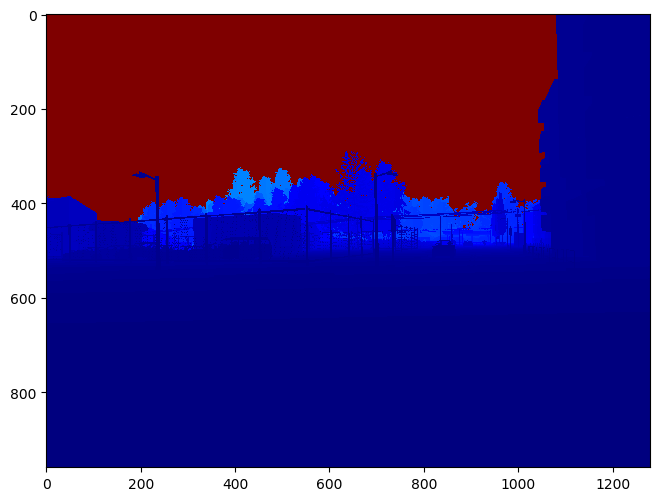

In [5]:
depth = dataset_handler.depth_maps[0]

plt.figure(figsize = (8,6), dpi = 100)
plt.imshow(depth, cmap = 'jet')

## 1 - Feature Extraction
### 1.1 - Extracting Features from an Image
There are many feature extractors and desciptors, for example, SIFT, FAST, ORB, SURF and BRIEF. We are going to use FAST for feature extraction and ORB for computing respective descriptors. You might find this link useful: [OpenCV:Feature Detection and Description](https://docs.opencv.org/3.4.3/db/d27/tutorial_py_table_of_contents_feature2d.html). 

In [6]:
def extract_features(image):
    """
    Find keypoints and descriptors for the image.
    
    Arguments:
    image -- grayscale image
    
    Returns:
    kp  -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    fast = cv2.FastFeatureDetector_create()
    kp = fast.detect(image,None)
    orb = cv2.ORB_create()
    kp, des = orb.compute(image, kp)
    
    return kp, des

In [7]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image
    
    Arguments:
    image -- a rgb image
    kp -- list of extracted keypoints
    
    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None)
    plt.imshow(display)

Number of features detected in frame 0: 8548

Coordinates of the first keypoint in frame 0: (1092.0, 31.0)


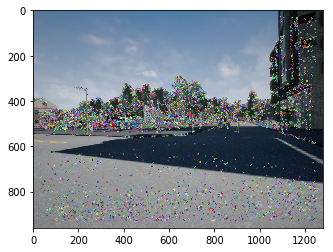

In [8]:
i = 0
image = dataset_handler.images_rgb[0]
kp, des = extract_features(image)
print("Number of features detected in frame {0}: {1}\n".format(i, len(kp)))
print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp[0].pt)))
visualize_features(image, kp)

### 1.2 - Extracting Features from Each Image in the Dataset
The following code will extract features for each image in the dataset with the `extract_features` function created above.

In [9]:
def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset
    
    Arguments:
    images                    -- list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) in an image
    
    Returns:
    kp_list  -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    """
    
    kp_list = []
    des_list =[]
    
    for i in range(len(images)):
        kp, des = extract_features_function(images[i])
        kp_list.append(kp)
        des_list.append(des)
        
    return kp_list, des_list

In [10]:
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

print("Number of features detected in frame {0}: {1}".format(0, len(kp_list[0])))
print("Coordinates of the first keypoint in frame {0}: {1}".format(0, str(kp_list[0][0].pt)))
print("Length of images array: {0}".format(len(images)))

Number of features detected in frame 0: 7880
Coordinates of the first keypoint in frame 0: (1092.0, 31.0)
Length of images array: 52


## 2 - Feature Matching
Next step after extracting features in each image is matching the features from the subsequent frames.
### 2.1 - Matching features from subsequent frames
In the following code we are writing a function that matches the features between two images. We use Brute Force Matcher for this process. OpenCV provides cv2.[BFMatcher](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html) function for this step.

In [11]:
def match_features(des1, des2):
    """
    Match features from two images
    
    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    
    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    
    bfm = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
    match = bfm.match(des1, des2)
    
    return match

Here we are defining a function that will filter the matches obtained from the Brute Force Matching process. The filtering process is done by thresholding the distance between the best matches. This might be useful for improving the overall trajectory estimation results.

**Note:** Using this function is optional. The project can be implemented without using it as well.

In [12]:
# Optional
def filter_matches_distance(match, dist_threshold):
    """
    Filter matched features from the two images by distance between the best matches
    
    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches
    
    Returns:
    filtered_match - list of good matches, satisfying te distance treshold
    """
    filtered_match = []
    
    for m in match:
        if m.distance < dist_threshold:
            filtered_match.append(m)
            
    return filtered_match

In [13]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize correponding matches in two images
    
    Arguments:
    image1 -- first image (grayscale) in a matched image pair
    kp1    -- list of the keypoints in the first image
    image2 -- second image (grayscale) in a matched image pair
    kp2    -- list of the keypoints in the second image
    match  -- list of matched features from the pair
    
    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None)
    plt.figure(figsize = (16, 6), dpi = 100)
    plt.imshow(image_matches)

Number of features matched in frames 0 and 1 after filtering by distance: 161


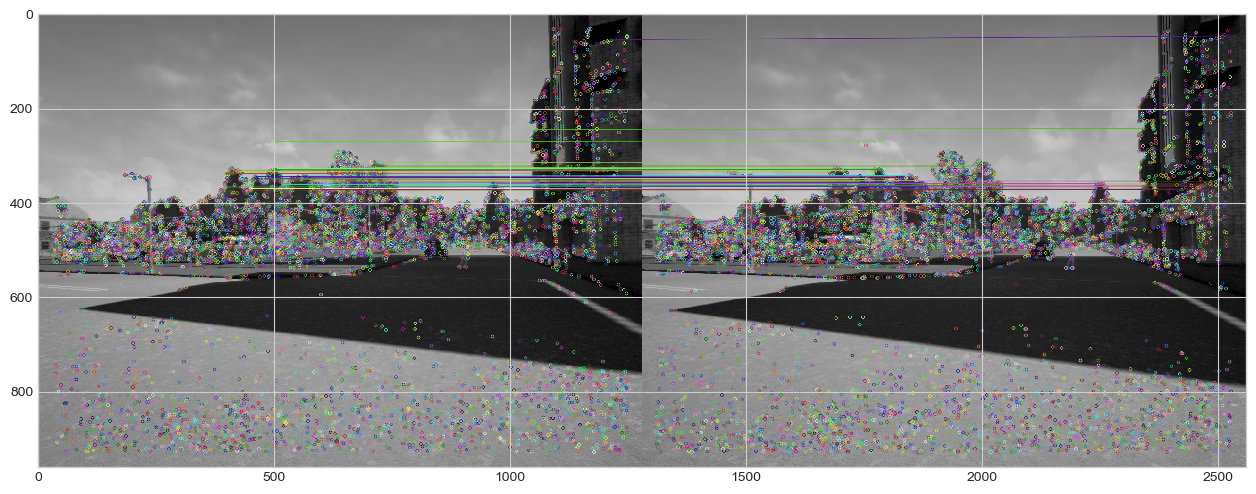

In [27]:
# Visualize n first matches, set n to None to view all matches
n = 50

# Set filtering to True if using match filtering, otherwise set to False
filtering = True

i = 0
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2)
if filtering:
    dist_threshold = 7
    match = filter_matches_distance(match, dist_threshold)
    print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(match)))
    images_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])

else:
    print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))
    images_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])
    

### 2.2 Matching Features in Each Subsequent Image Pair in the Dataset
The following code will match features for each subsequent image pair in the dataset with the `match_features` and `filter_matches_distance` functions created above.

In [15]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset
    
    Arguments:
    des_list       -- list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1 
    """
    matches = []
    
    for i in range(len(des_list) - 1):
        match = match_features(des_list[i], des_list[i+1])
        matches.append(match)
        
    return matches

In [16]:
# Optional
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold = 40):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches                 -- list of matches for each subsequent image pair in the dataset. Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold          -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = []
    
    for match in matches:
        filtered_match = filter_matches_distance(match, dist_threshold)
        filtered_matches.append(filtered_match)
        
    return filtered_matches

In [17]:
dist_treshold = 7
filtering = True

matches = match_features_dataset(des_list, match_features)

if filtering:
    matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)

i = 0
print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of filtered matches in frames 0 and 1: 161


## 3 - Trajectory Estimation
In this section we will incrementally estimate the pose of the vhicle by examining the changes that motion induces on the images of its onboard camera.

### 3.1 - Estimating Camera Motion between a Pair of Images
Now, we will estimate camera motion from a pair of images. We will be using Perspective-n-Point (PnP) algorithm for estimating the motion of camera. PnP algorithm requires depth maps of frame (provided with the dataset handler)

In [18]:
def estimate_motion(match, kp1, kp2, k, depth1=[]):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame.

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3,1))
    
    image1_points = []
    image2_points = []
    
    object_points = np.array([[],
                              [],
                              []])
    
    for m in match:
        image1_index = m.queryIdx
        image1_u, image1_v = kp1[image1_index].pt
        image1_u_index, image1_v_index = int(image1_u), int(image1_v)
        
        depth = depth1[image1_v_index, image1_u_index]
        if depth < 1000:
            image1_points.append([image1_u, image1_v])
            
            image1_3D = depth * np.array([[image1_u], 
                                          [image1_v], 
                                          [1]])
            image1_3D = np.linalg.inv(k) @ image1_3D
            
            object_points = np.c_[object_points, image1_3D]
            
            image2_index = m.trainIdx
            image2_u, image2_v = kp2[image2_index].pt
            image2_points.append([image2_u, image2_v])
            
    image_points = np.array(image2_points)
    image_points = image_points.astype("Float64")
    object_points = object_points.transpose()
    dist_coeffs = np.zeros(4)
    
    # Try changing values for 'reprojectionError' and 'iterationsCounts' to understand its effects on the output.
    _, rmat, tvec, inliers = cv2.solvePnPRansac(objectPoints = object_points, 
                                                imagePoints = image_points, 
                                                cameraMatrix = k, 
                                                distCoeffs = dist_coeffs, 
                                                reprojectionError = 5.5, 
                                                iterationsCount = 1000)
    rmat, _ = cv2.Rodrigues(rmat)
    
    return rmat, tvec, image1_points, image2_points

Now let us visualize the output of the algorithm for single pair of subsequent images.

In [19]:
i = 0
match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k  = dataset_handler.k
depth = dataset_handler.depth_maps[i]
rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1 = depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

Estimated rotation:
 [[ 9.99983325e-01 -5.54060022e-03  1.62838276e-03]
 [ 5.54140338e-03  9.99984527e-01 -4.89130336e-04]
 [-1.62564749e-03  4.98145706e-04  9.99998555e-01]]
Estimated translation:
 [[ 0.00337939]
 [-0.00688683]
 [-0.32839144]]


c:\python36\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


**Camera Movement Visualization:** Final image matches from an image pair can be visualized using the `visualize_camera_movement` function. The final image matches are connected with an arrow corresponding to direction of camera movement (when `is_show_img_after_mov = False`)

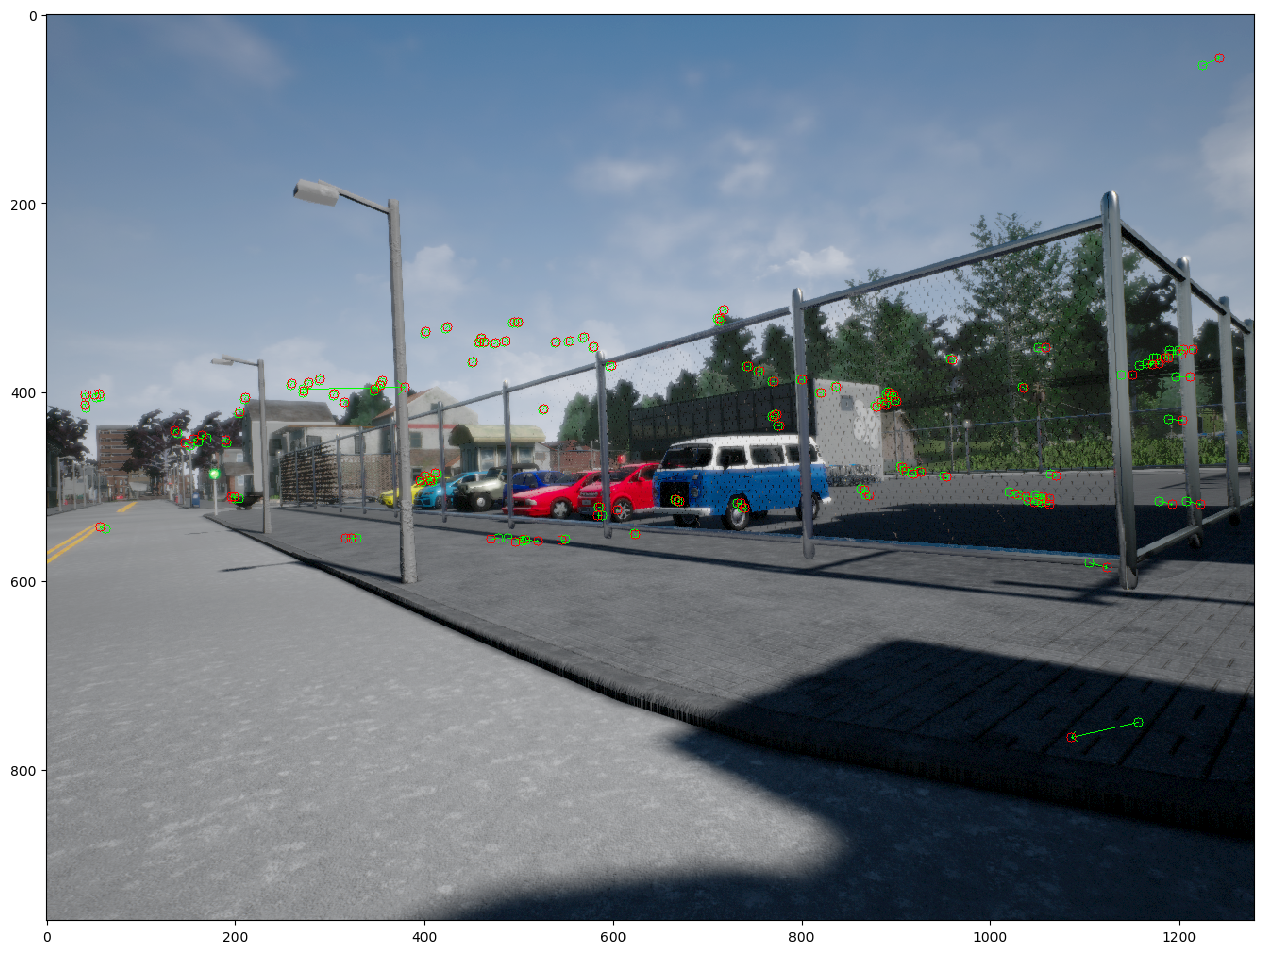

In [20]:
i = 30
image1 = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i+1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize = (16,12), dpi = 100)
plt.imshow(image_move)

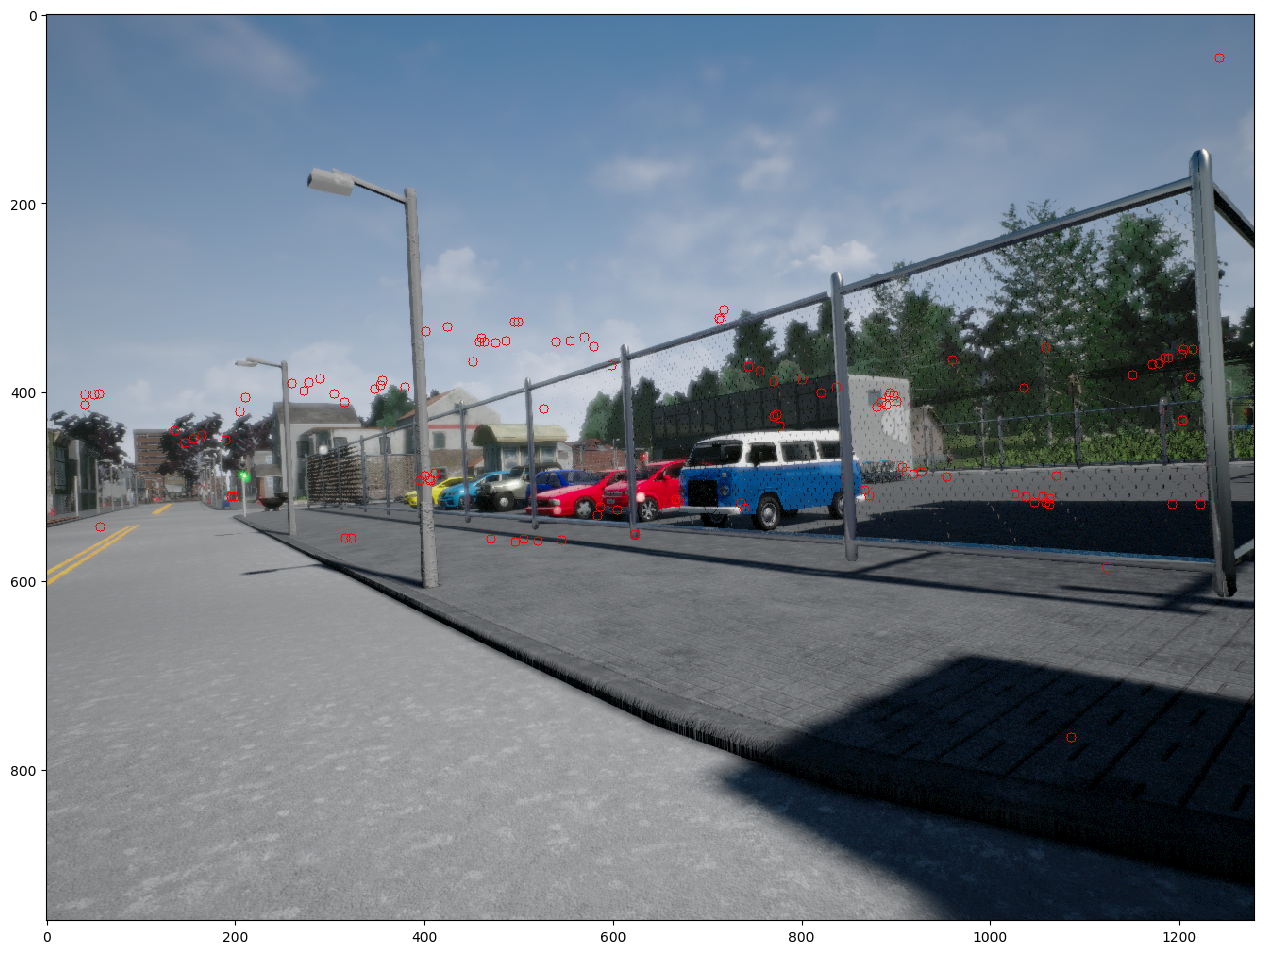

In [21]:
image_move = visualize_camera_movement(image1, image1_points, image2, image2_points, is_show_img_after_move = True)
plt.figure(figsize = (16,12), dpi = 100)
plt.imshow(image_move)

### 3.2 - Camera Trajectory Estimation
In this section we will be estimating the camera trajectory with visual odometry. More specifically, we will be implementing camera motion estimation for each subsequent image pair in the dataset with the function written above.

In [22]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps = []):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches         -- list of matches for each subsequent image pair in the dataset. Each matches[i] is a list of matched features from images i and i + 1
    des_list        -- a list of keypoints for each image in the dataset
    k               -- camera calibration matrix 
    
    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven 
                  at the initialization of this function
    """
    trajectory = np.zeros((3,1))
    P = np.eye(4)
    
    for i, match in enumerate(matches):
        R, t, image1_points, image2_points = estimate_motion(match, 
                                                             kp_list[i], 
                                                             kp_list[i+1], 
                                                             k, 
                                                             depth1 = depth_maps[i])
        
        P_new = np.eye(4)
        P_new[0:3, 0:3] = R.T
        C = -R.T @ t
        P_new[0,3] = C[0,0]
        P_new[1,3] = C[1,0]
        P_new[2,3] = C[2,0]
        
        P = P @ P_new
        
        X = np.array([[P[0,3]], 
                      [P[1,3]], 
                      [P[2,3]]])
        trajectory = np.c_[trajectory, X]
        
    return trajectory

In [23]:
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, 
                                 matches, 
                                 kp_list, 
                                 k, 
                                 depth_maps = depth_maps)

i = 1
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

c:\python36\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


Camera location in point 1 is: 
 [[-0.00387502]
 [ 0.00706903]
 [ 0.32838209]]

Length of trajectory: 52


## 4 - Put it all together!
Great! So now that we are done building the necessary functions to carry out the four tasks mentioned in the beginning of the notebook, we can put it all together and estimate the trajectory for the entire data set.

In [32]:
# Creating object for dataset handler and loading the dataset.
# dataset_handler = DatasetHandler() (Uncomment this line if you have modified original data.)

k = dataset_handler.k
# Feature Extraction
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

# Feature Matching
matches = match_features_dataset(des_list, match_features)

# (Optional) Filter the matches
filtering = True # Set to False if you want to skip filtering
if filtering:
    dist_threshold = 7
    filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)
    matches = filtered_matches
    
# Trajectory Estimation
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, 
                                 matches, 
                                 kp_list, 
                                 k, 
                                 depth_maps = depth_maps)

print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

c:\python36\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


Trajectory X:
 [[  0.          -0.00387502  -0.01915526  -0.05378727  -0.06073839
   -0.08596741  -0.09998783  -0.15042894  -0.19164006  -0.23264065
   -0.28184418  -0.31842829  -0.37263704  -0.45232348  -0.56343898
   -0.70994799  -0.85748118  -1.0004799   -1.12447537  -1.24422069
   -1.38529813  -1.55925795  -1.7500313   -1.97762371  -2.2048898
   -2.41640658  -2.62615337  -2.82024987  -3.00372831  -3.2287531
   -3.46515788  -3.7458621   -4.04960127  -4.39558108  -4.51176572
   -4.92268645  -5.38465731  -5.80750528  -6.23259917  -6.67611129
   -7.1255436   -7.532139    -7.95979424  -8.39193086  -8.83110003
   -9.2371577   -9.63511703 -10.0204665  -10.41194854 -10.76397212
  -11.09214658 -11.35734075]]
Trajectory Y:
 [[0.         0.00706903 0.01624823 0.03215476 0.03850549 0.0435299
  0.04721758 0.05272598 0.05669521 0.06619429 0.07008634 0.07833375
  0.07784478 0.08609442 0.08906491 0.10640283 0.11102633 0.11902814
  0.12227077 0.13058889 0.14085705 0.1586136  0.17334542 0.19077415
 

Now, let us visualize the estimated trajectory using `visualize trajecotry` function provided in `helper_functions` package.

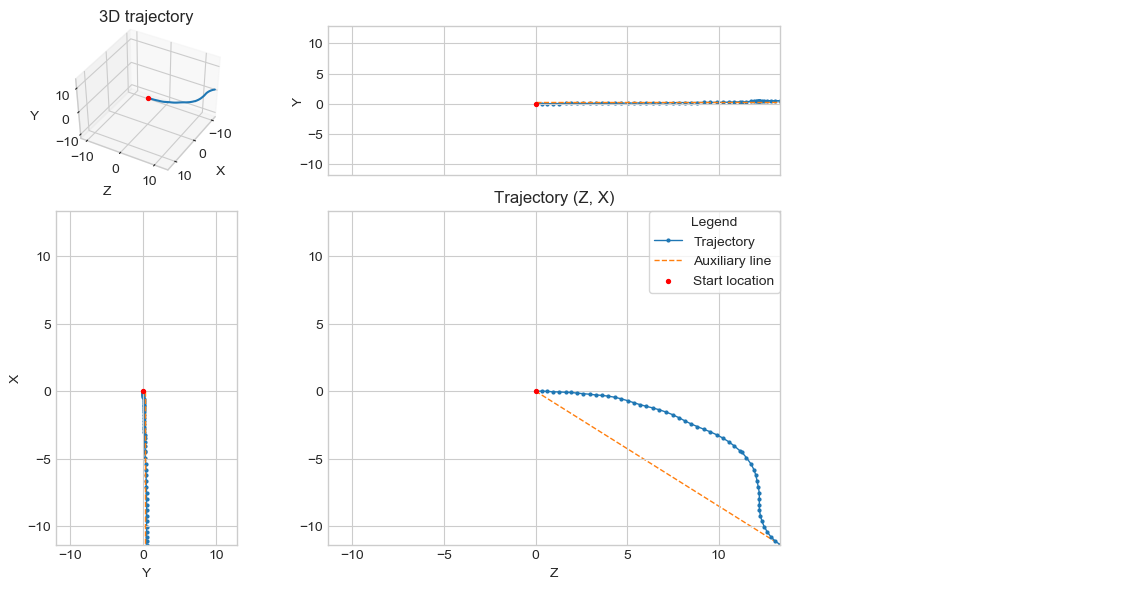

In [33]:
visualize_trajectory(trajectory)